In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import HTML
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models
import torchvision.datasets as datasets
import numpy as np
import torchvision.utils as utils
import torch.nn.functional as F
from scipy import linalg
import matplotlib.pyplot as plt


In [2]:
dataset = datasets.CIFAR10(root="/home/sandyap/data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

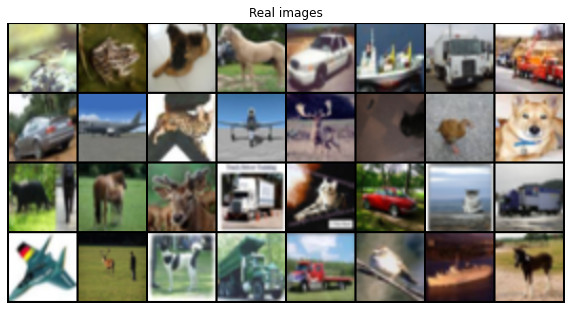

In [3]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
def initialize_weights(model):
    # Initialize weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
gen = Generator(channels_noise = 100, channels_img = 3, features_g = 64).to(device)
disc = Discriminator(channels_img = 3, features_d = 64).to(device)
initialize_weights(gen)
initialize_weights(disc)
lr = 2e-4

In [8]:
optimGenerator = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, 100, 1, 1).to(device)
step = 0

In [9]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
#training block
GenLoss1 = []
DiscLoss1 = []
img_list1 = []
real_list1=[]
iters = 0

print("!!Training Started!!")
# start timing
time_start = time.time()
num_epochs = 15
for epoch in range(num_epochs):
    epoch = epoch+1

    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        noise = torch.randn(128, 100, 1, 1).to(device)
        fake = gen(noise) #genrator img data

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}"
            )
        #saving the losses for every 100 batch
        GenLoss1.append(loss_gen.detach().cpu())
        DiscLoss1.append(loss_disc.detach().cpu())
        
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list1.append(utils.make_grid(fake, padding=2, normalize=True))
            real_list1.append(utils.make_grid(real, padding=2, normalize=True))
            
        iters += 1

!!Training Started!!
Epoch [1/15] Batch 0/1563                   Loss Discriminator: 0.693, loss Generator: 0.738
Epoch [1/15] Batch 100/1563                   Loss Discriminator: 0.088, loss Generator: 4.844
Epoch [1/15] Batch 200/1563                   Loss Discriminator: 0.202, loss Generator: 2.652
Epoch [1/15] Batch 300/1563                   Loss Discriminator: 0.250, loss Generator: 2.029
Epoch [1/15] Batch 400/1563                   Loss Discriminator: 0.352, loss Generator: 1.897
Epoch [1/15] Batch 500/1563                   Loss Discriminator: 0.519, loss Generator: 1.311
Epoch [1/15] Batch 600/1563                   Loss Discriminator: 0.557, loss Generator: 1.492
Epoch [1/15] Batch 700/1563                   Loss Discriminator: 0.427, loss Generator: 1.538
Epoch [1/15] Batch 800/1563                   Loss Discriminator: 0.507, loss Generator: 1.300
Epoch [1/15] Batch 900/1563                   Loss Discriminator: 0.585, loss Generator: 1.416
Epoch [1/15] Batch 1000/1563   

In [13]:
# now using........
import math
def IS(img_list, model, num_splits=10, normalize=True):
    scores = []
    softmax = F.softmax(img_list, dim=1)
    split_scores = []
    for i in range(num_splits):
        #print('debug2')
        fraction = softmax.size(0) // num_splits
        #print(fraction)
        #print(fraction)
        split = softmax[i * fraction : (i + 1) * fraction, :]
        #print('split')
        #print(split)
        kl = split * (torch.log(split) - torch.log(torch.mean(split, dim=0, keepdim=True)))
        kl = kl.sum(dim=1)
        score_i = torch.exp(torch.mean(kl))
        split_scores.append(score_i)
            #print(split_scores)
    scores.append(torch.mean(torch.stack(split_scores)))
    # Compute the final score
    score = torch.mean(torch.stack(scores))
    if normalize:
        score /= math.exp(1)
    return score.item()


In [14]:
def extract_features(img_list, model):
    model.eval()
    img_features_list = []
    for img_batch in img_list:
        img_batch = img_batch.to(device)
        img_features = model(img_batch)[0]
        if img_features.ndim < 2:
            img_features = img_features.unsqueeze(0)
        img_features = F.adaptive_avg_pool2d(img_features, output_size=1)
        img_features = img_features.view(img_features.size(0), -1)
        img_features_list.append(img_features)
    return torch.cat(img_features_list, dim=0)


In [15]:
#from torchmetrics.image.inception import InceptionScore
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=True, transform_input=False).to(device).eval()

In [16]:
img_sq = [img.unsqueeze(0) for img in img_list1]
features = extract_features(img_sq, inception_model)
score = IS(features, inception_model)
#IS(img_list,inception_model,32)
score

0.3678794503211975

In [ ]:
from scipy.spatial.distance import cdist

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # calculate sqrt of product of covariances
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # calculate the FID score using Nearest Neighbor approximation
    mu1 = mu1.reshape(1, -1)
    mu2 = mu2.reshape(1, -1)
    m = cdist(mu1, mu2, metric='euclidean')
    s = np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return m[0, 0] + s


In [ ]:
act1=np.empty((len(real_list1), 2048))

mu1 = np.mean(act1, axis=0)

sigma1 = np.cov(act1, rowvar=False)

act2=np.empty((len(img_list1), 2048))

sigma2 = np.cov(act2, rowvar=False)

mu2 = np.mean(act2, axis=0)

mu1 = np.atleast_1d(mu1)
mu2 = np.atleast_1d(mu2)

sigma1 = np.atleast_2d(sigma1)
sigma2 = np.atleast_2d(sigma2)
fid=calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
prtin(fid)

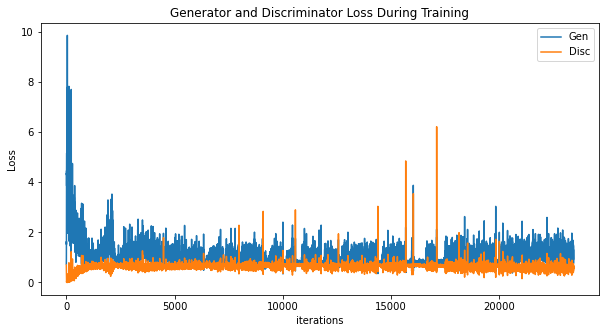

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss1,label="Gen")
plt.plot(DiscLoss1,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

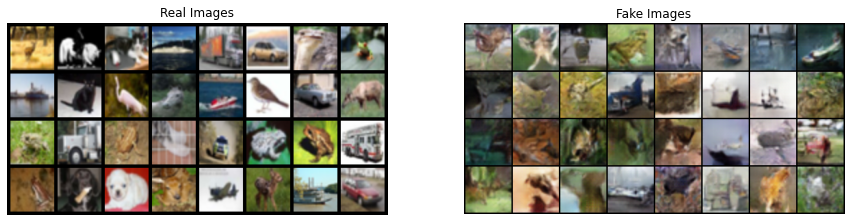

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()